# Getting started with the natural gradient plugin

In this notebook, you will learn how to use an advanced plugin for variational optimization.

This plugin can perform a **gradient-descent optimization** based on the computation of the exact gradient of the energy with respect to the variational parameters, as well as a more advanced **'natural-gradient' optimization**.

## Description of the variational task

Here, we want to minimize the value of $\langle Y_0 \rangle$ with a simple Ansatz described in the cell below:

In [1]:
import numpy as np
from qat.core import Observable, Term
from qat.lang.AQASM import Program, RX, RY, RZ, CNOT

nbqbits = 2

obs = Observable(nbqbits, pauli_terms=[Term(1, "Y", [0])])

prog = Program()
reg = prog.qalloc(nbqbits)

RY(np.pi / 4)(reg[0])
RY(np.pi / 3)(reg[1])
RZ(prog.new_var(float, "\\theta_0"))(reg[0])
RZ(prog.new_var(float, "\\theta_1"))(reg[1])
CNOT(reg[0], reg[1])
RY(prog.new_var(float, "\\theta_2"))(reg[1])
CNOT(reg[0], reg[1])

circ = prog.to_circ()

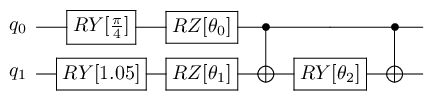

In [2]:
circ.display()

## Initializing the plugin

We now instantiate the plugin with its two modes (plain-vanilla gradient or natural gradient) and perform the optimization:

In [3]:
import time
from qat.qpus import get_default_qpu
from qat.plugins import GradientDescentOptimizer  # do we want to keep this plugin name / this module name?

qpu = get_default_qpu()

step = 0.2

natgrad_plugin = GradientDescentOptimizer(maxiter=200, lambda_step=step, natural_gradient=True, tol=1e-7)
grad_plugin = GradientDescentOptimizer(maxiter=200, lambda_step=step, natural_gradient=False, tol=1e-7)

natgrad_stack = natgrad_plugin | qpu
grad_stack = grad_plugin | qpu

res = {}

In [4]:
start = time.time()
res["natural gradient"] = natgrad_stack.submit(circ.to_job(job_type="OBS", observable=obs))
print(f"Elapsed time for natural gradient descent : {time.time() - start:.3f} sec")

Elapsed time for natural gradient descent : 4.006 sec


In [5]:
start = time.time()
res["gradient descent"] = grad_stack.submit(circ.to_job(job_type="OBS", observable=obs))
print(f"Elapsed time for gradient descent : {time.time() - start:.3f} sec")

Elapsed time for gradient descent : 2.183 sec


## Comparing to other plugins

For comparison, we also run the same optimization with other variational plugins from the QLM:

In [6]:
from qat.plugins import ScipyMinimizePlugin, PSOMinimizePlugin, SPSAMinimizePlugin

methods = ["COBYLA", "BFGS", "PSO", "SPSA"]
plugins = {
    "COBYLA": ScipyMinimizePlugin(method="COBYLA"),
    "BFGS": ScipyMinimizePlugin(method="BFGS"),
    "PSO": PSOMinimizePlugin(),
    "SPSA": SPSAMinimizePlugin(),
}
for method in methods:
    stack = plugins[method] | qpu
    start = time.time()
    res[method] = stack.submit(circ.to_job(job_type="OBS", observable=obs))
    print(f"Elapsed time for {method} : {time.time() - start:.3f} sec")

Elapsed time for COBYLA : 0.193 sec
Elapsed time for BFGS : 0.142 sec
Elapsed time for PSO : 0.380 sec
Elapsed time for SPSA : 0.569 sec


## Plotting the results

final value (COBYLA): -0.7071067804700052
final value (BFGS): -0.7071067811235484
final value (PSO): -0.6313028061230416
final value (SPSA): -0.6492440411721022
final value (natural gradient): -0.7071067811865464
final value (gradient descent): -0.7071063491542352


(0.0, 40.0)

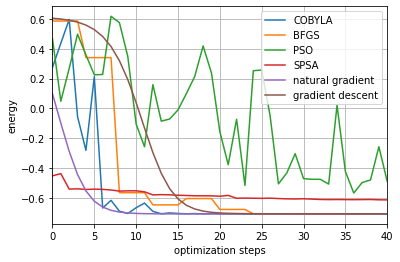

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
for method in ["COBYLA", "BFGS", "PSO", "SPSA", "natural gradient", "gradient descent"]:
    print(f"final value ({method}): {res[method].value}")
    vals = res[method].meta_data["optimization_trace"]
    plt.plot(eval(vals) if isinstance(vals, str) else vals, label=method)
plt.legend()
plt.grid()
plt.ylabel("energy")
plt.xlabel("optimization steps")
plt.xlim(0, 40)